In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil, sqrt
import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

warnings.filterwarnings('ignore')
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
#torch.use_deterministic_algorithms(True)
#Сброс ограничений на число столбцов
#pd.options.display.max_columns = None
RANDOM_STATE=12345

GPU is available and being used


In [2]:
import requests
TOKEN = "6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA"
url = f"https://api.telegram.org/bot6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA/getUpdates"
print(requests.get(url).json())

TOKEN = "6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA"
chat_id = "916785354"
message = "Done!"
url = f"https://api.telegram.org/bot6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA/sendMessage?chat_id=916785354&text=Done!"

{'ok': True, 'result': []}


## Загрузка данных

In [3]:
#df = pd.read_excel('stars.xlsx', sheet_name='stars')


df = pd.read_csv('stars.csv', sep='\t')
#df = pd.read_csv('/datasets/6_class.csv')

## Предобработка и анализ данных

In [4]:
df

,Unnamed: 0.1,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...,...,...
235,235,235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,236,236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,237,237,8829,537493.000000,1423.0000,-10.73,5,White
238,238,238,9235,404940.000000,1112.0000,-11.23,5,White


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0.1            240 non-null    int64  
 1   Unnamed: 0              240 non-null    int64  
 2   Temperature (K)         240 non-null    int64  
 3   Luminosity(L/Lo)        240 non-null    float64
 4   Radius(R/Ro)            240 non-null    float64
 5   Absolute magnitude(Mv)  240 non-null    float64
 6   Star type               240 non-null    int64  
 7   Star color              240 non-null    object 
dtypes: float64(3), int64(4), object(1)
memory usage: 15.1+ KB


Без пропусков - это прекрасно. Непонятная первая колонка - без названия, целочисленная.

In [6]:
df.sample(8)

,Unnamed: 0.1,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
232,232,232,32489,648430.00000,1948.50,-10.840,5,Blue
30,30,30,39000,204000.00000,10.60,-4.700,3,Blue
216,216,216,9320,29.00000,1.91,1.236,3,Blue-white
52,52,52,3834,272000.00000,1183.00,-9.200,5,Red
94,94,94,9030,45.00000,2.63,1.450,3,Blue-white
122,122,122,3218,0.00054,0.11,20.020,0,Red
213,213,213,22012,6748.00000,6.64,-2.550,3,Blue-white
95,95,95,11250,672.00000,6.98,-2.300,3,Blue-white


Первая колонка - это индекс, удалю. В последней вижу необходимость приведения слов к одинаковому написанию.

In [7]:
#df = df.drop('Unnamed: 0', axis=1)

df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [8]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


В этих данных категории в колонке 'Star type' и 'Star color'. Со 'Star type' будет коррелировать абсолютно всё, потому что типы как раз выделяются за счёт группировки объектов в кластеры, так можно сказать. И у каждого кластера определённые параметры.

Рассмотрим значения цветов. Вызывают сомнения 'yellowish' и сложные цвета. Оказывается, "желтоватый" вполне нормальный термин, а "Blue-white" и "Blue white" не одинаковые цвета в таблицах классификации (можно ознакомиться, например, здесь => https://kosmosgid.ru/zvyozdy/klassi-zvezd). Однако, у конкретной звезды должен быть один цвет, поэтому считаю уместным в двойных словах ставить тире. Нам дано, что этот параметр определён по спектру, а не по таблице классификации, поэтому должен быть однозначным. 

In [9]:
df['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish',
       'Yellowish', 'Orange-Red', 'Blue-White'], dtype=object)

In [10]:
star_color = {
'Red':'red', 
'Blue White':'blue-white', 
'White':'white', 
'Yellowish White':'yellowish-white', 
'Blue white':'blue-white',
'Pale yellow orange':'yellow-orange', 
'Blue':'blue', 
'Blue-white':'blue-white', 
'Whitish':'whitish',
'yellow-white':'yellow-white', 
'Orange':'orange', 
'White-Yellow':'yellow-white', 
'Blue ':'blue',
'Yellowish':'yellowish', 
'Orange-Red':'orange-red', 
'Blue white ':'blue-white',
'Blue-White':'blue-white' }  
df['Star color'] = df['Star color'].replace(star_color)
df['Star color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white', 'yellow-orange',
       'blue', 'whitish', 'yellow-white', 'orange', 'yellowish',
       'orange-red'], dtype=object)

In [11]:
df.groupby('Star color').agg({'Temperature (K)':['min','max','count']})

Temperature (K)             
                            min    max count
Star color                                  
blue                       5752  40000    56
blue-white                 8570  30000    41
orange                     3749   4287     2
orange-red                 5112   5112     1
red                        1939   6850   112
white                      7220  14732    10
whitish                    8052   9700     2
yellow-orange              7230   7230     1
yellow-white               5300   8250     9
yellowish                  4077   4980     3
yellowish-white            7700  12990     3

В каких-то категориях будет маловато объектов, но таковы данные. 

In [12]:
df.duplicated().sum()

0

Дубли отсутствуют.

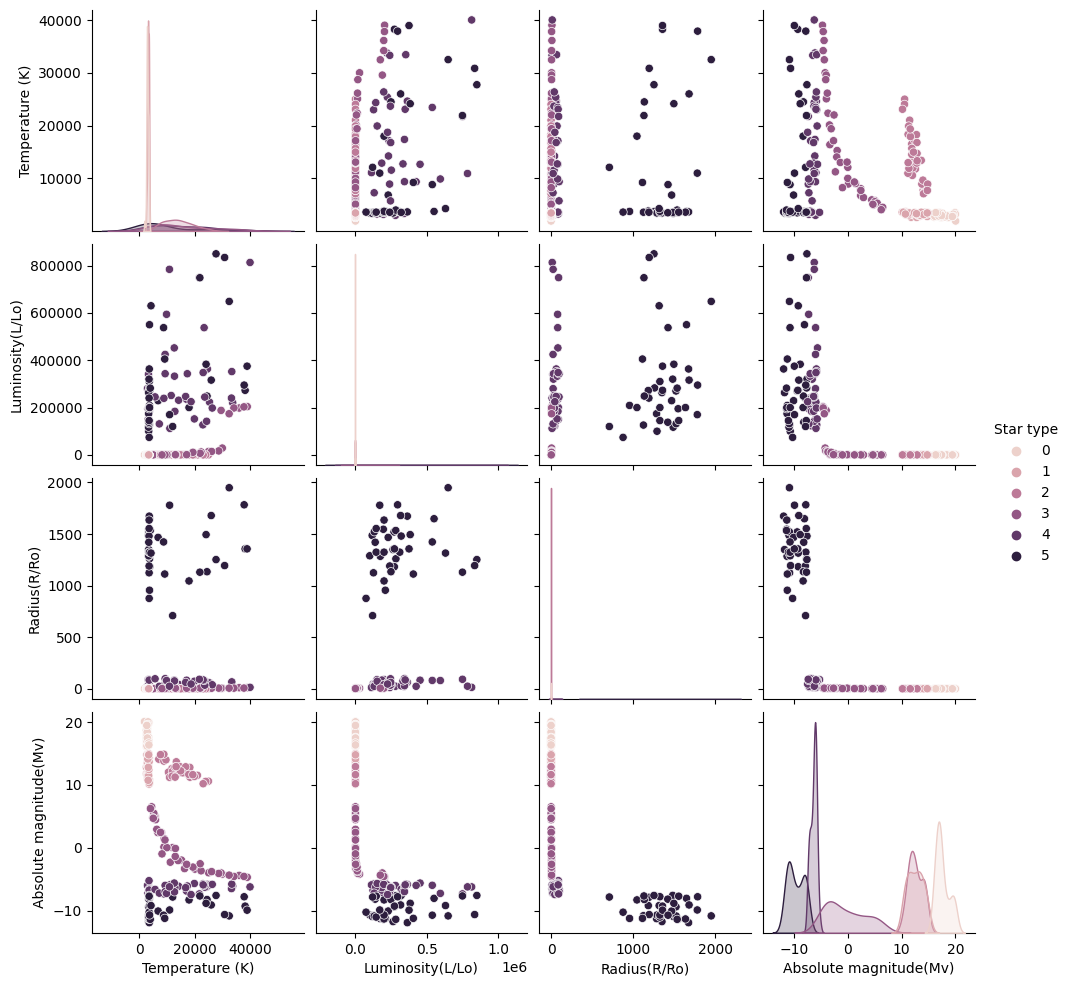

In [13]:
sns.pairplot(df, hue='Star type');

Между абсолютными температурой и звёздной величиной вырисовывается известная зависимость Герцшпрунга-Рассела(спектр/светимость) с главной последовательностью и областями гигантов и молодых звёзд. 
Радиус нам показывает, что в большинстве звёзды сравнимы с нашим Солнцем и только гипергиганты занимают большую площадь графиков (имеют сильный разброс значений радиуса). 
Также гипергиганты и сверхгиганты имеют отрицательную абсолютную звёздную величину и группируются в левой части графика.
В светимости тоже видим разброс значений для сверхгигантов и гипергигантов, но также и звёзды главной последовательности при высоких температурах могут демонстрировать разнообразие значений светимости. 

In [14]:
columns = df.columns


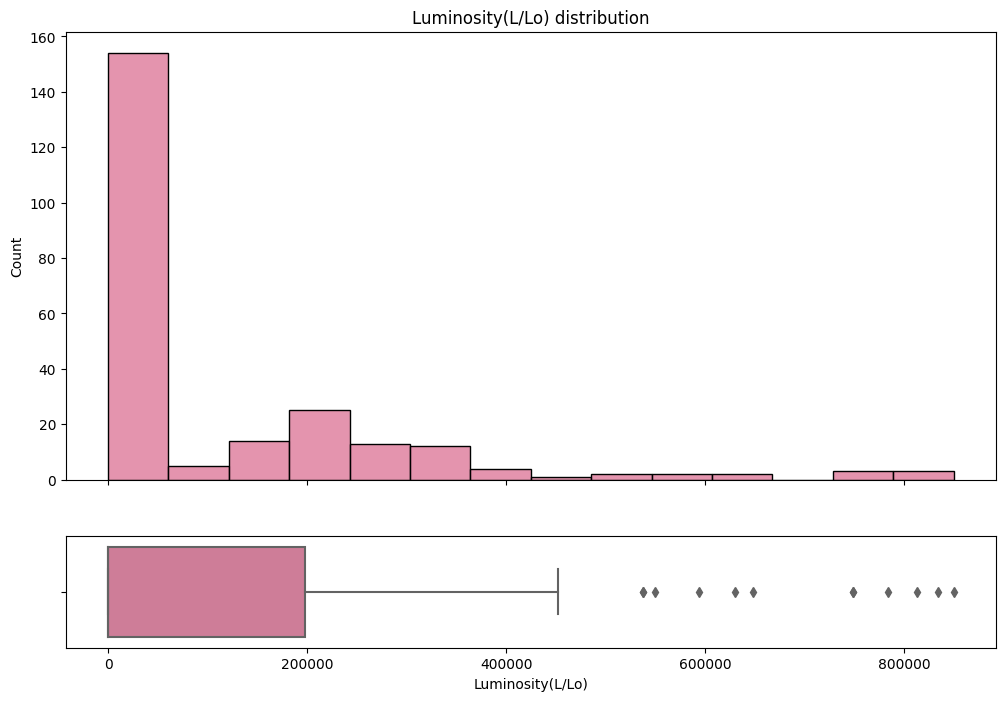

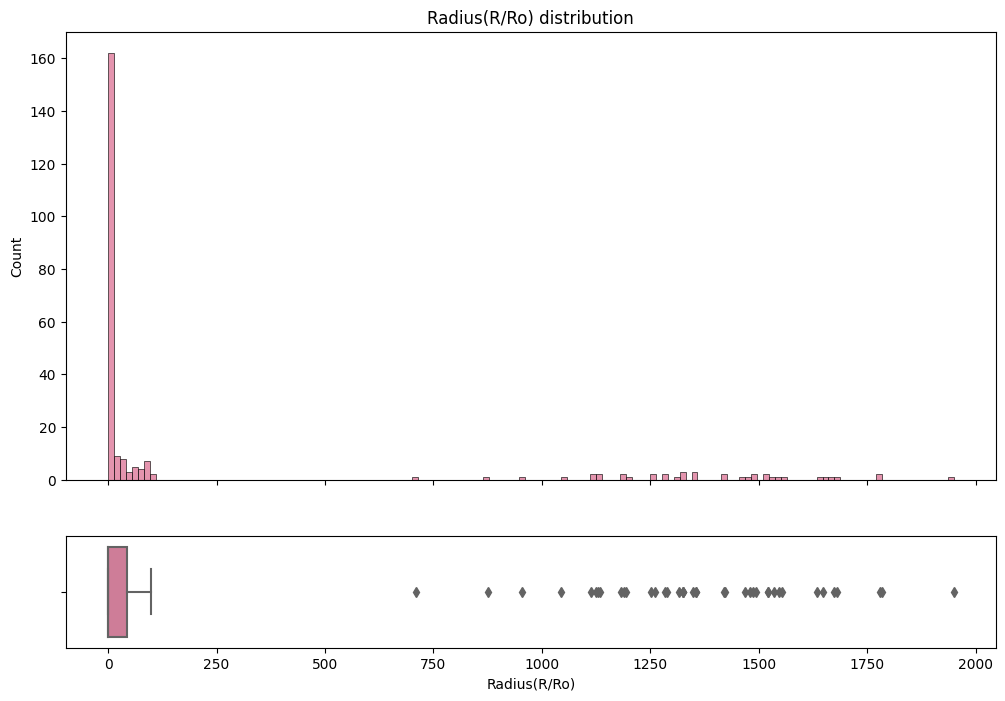

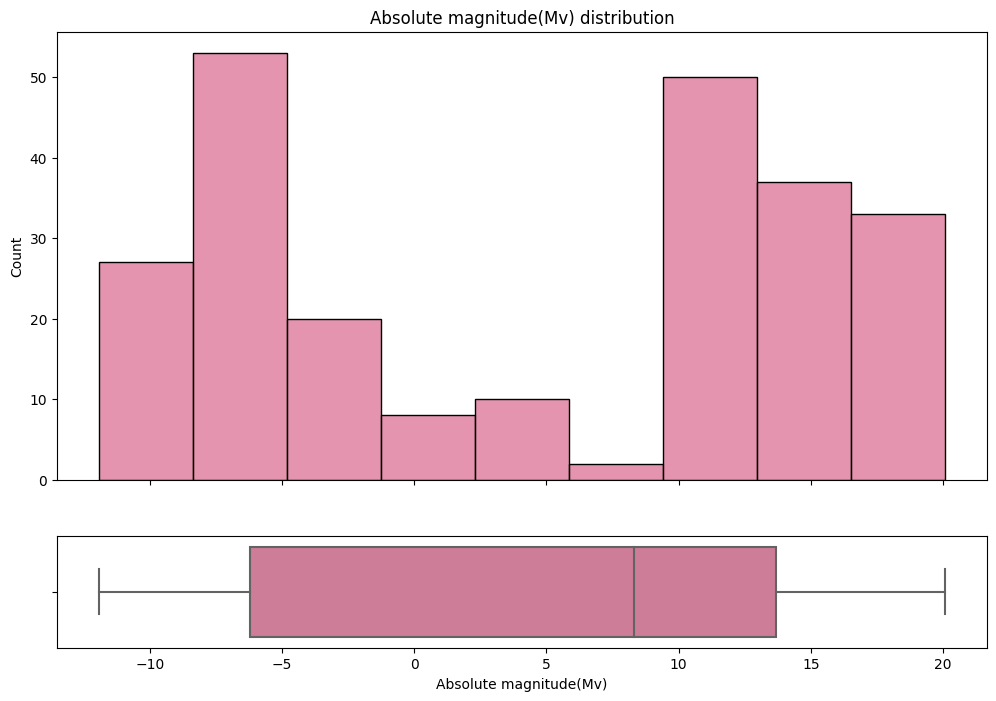

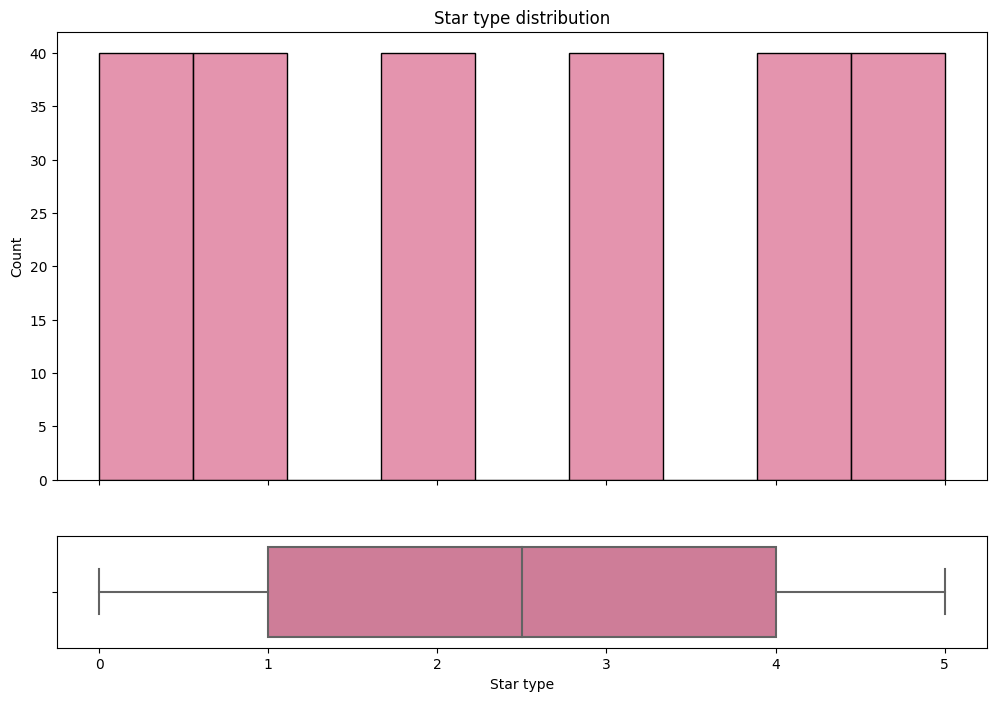

In [15]:
for i in columns[1:-1]:
    fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

    sns.histplot(x=df[i], ax=ax_hist, color='palevioletred')
    sns.boxplot(x=df[i], ax=ax_box, color='palevioletred')

    ax_box.set(xlabel=i)
    ax_hist.set(ylabel='Count')
    ax_hist.set(title=i+' distribution')
    plt.show()


  

Все типы представлены равным количеством звёзд, и при этом их характеристики разнообразны.
Светимость в основном низкая с небольшим всплеском в первой четверти, радиус маленький, с промежутком между гигантами и остальными, а звёздная величина имеет два максимума.

Рассмотрим целевой признак.

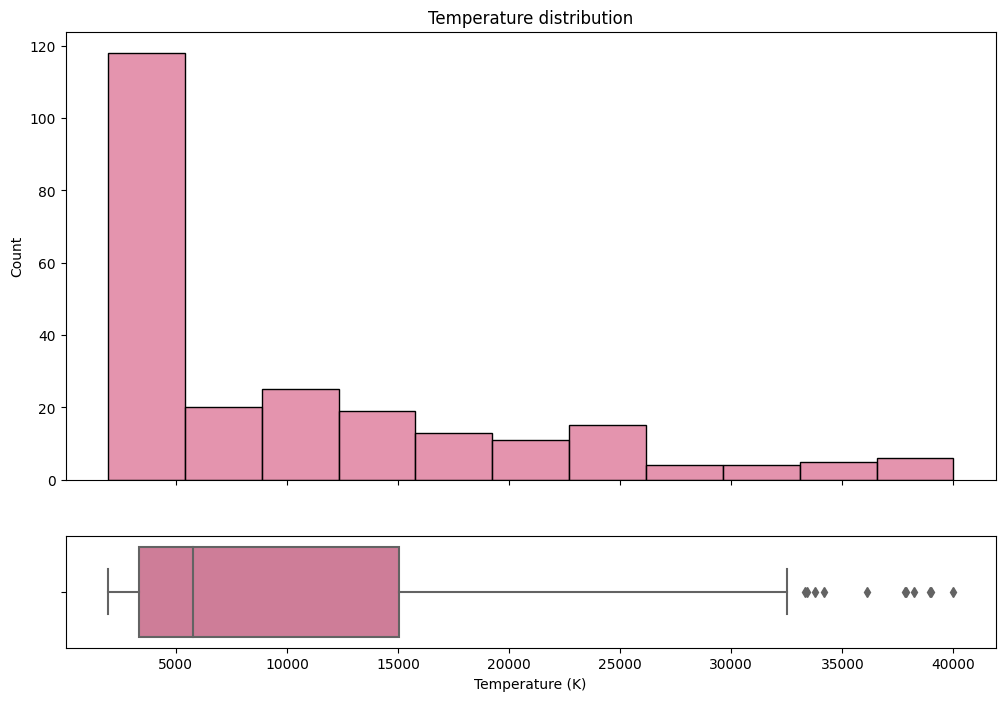

In [16]:

fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=df['Temperature (K)'], ax=ax_hist, color='palevioletred')
sns.boxplot(x=df['Temperature (K)'], ax=ax_box, color='palevioletred')

ax_box.set(xlabel='Temperature (K)')
ax_hist.set(ylabel='Count')
ax_hist.set(title='Temperature distribution')
plt.show()

Основная масса звёзд приходится на низкие температуры и медленное горение, что примерно соответствует ситуации в общем (http://www.astronet.ru/db/msg/1177040/chapter7_05.html - до 90% звёзд относятся к нормальным) . Особенные звёзды не будем отбрасывать - данных мало, и такие объекты действительно обнаружены.

Посмотрим, что показывает матрица корреляций.

<Axes: >

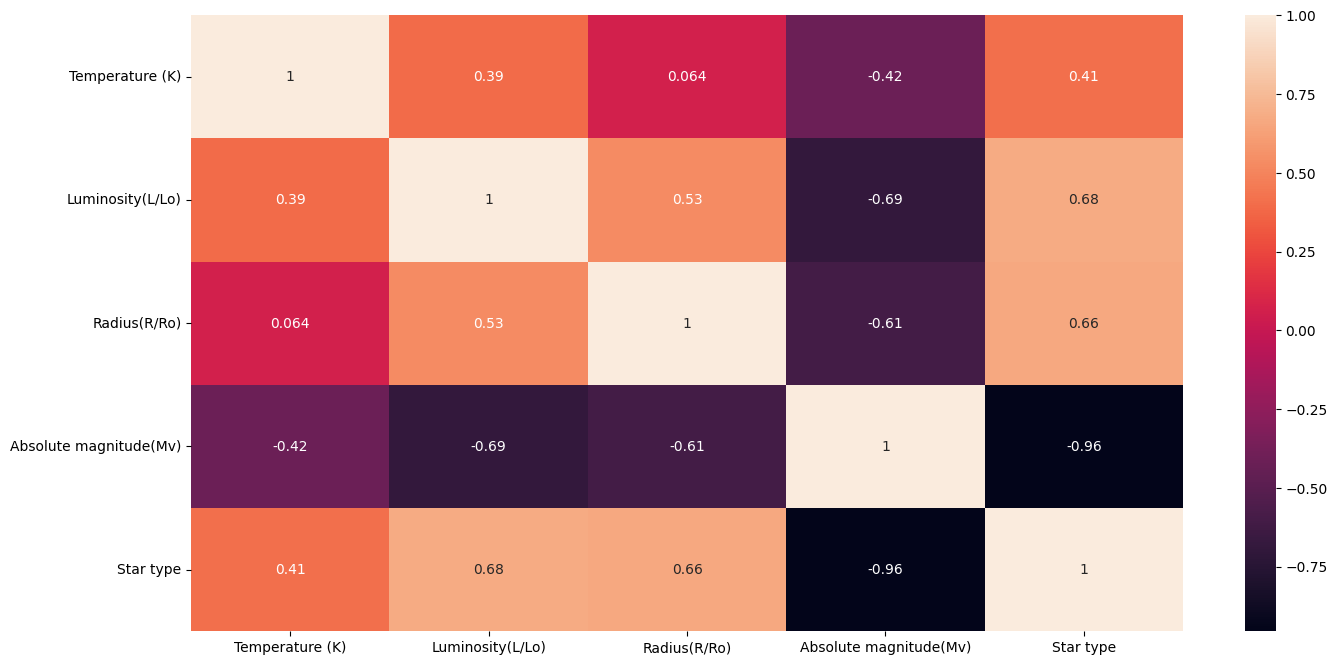

In [17]:
correlation_matrix = df.corr()

plt.figure(figsize= (16, 8))
sns.heatmap(correlation_matrix, annot = True)

Температура напрямую коррелирует со светимостью и типом звезды, и обратно коррелирует с абсолютной звёздной величиной.

Абсолютная звёздная величина показывает обратную зависимость от всех признаков, особенно сильно связана с типом звезды, и это действительно так.

Надо перевести значения колонки 'Star type' в строки, иначе дальше не хочет кодировщик обрабатывать числа как категории.

In [18]:
df['Star type'] = df['Star type'].astype('str')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    object 
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


Теперь нужно разделить данные на таргет и фичи, на обучающую, тестовую и валидационную выборки.

Отделяю 30 процентов на тест и валидацию, остальное оставляю сети на обучение.

In [20]:
X = df.drop('Temperature (K)', axis=1)
y = df['Temperature (K)']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, random_state=RANDOM_STATE, shuffle=True)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.5, random_state=RANDOM_STATE, shuffle=True)

In [21]:
what_words = ['Тренировочных признаков','Тренировочных целей', 'Тестовых признаков', 
        'Тестовых целей','Валидационных признаков', 'Валидационных целей']
what_arrs = [y_train, X_train, y_test, X_test, y_valid, X_valid]

for i in range(len(what_words)):
    print(f'{what_words[i]} {what_arrs[i].shape[0]*100/df.shape[0]:.0f}% от общей выборки.')

Тренировочных признаков 70% от общей выборки.
Тренировочных целей 70% от общей выборки.
Тестовых признаков 15% от общей выборки.
Тестовых целей 15% от общей выборки.
Валидационных признаков 15% от общей выборки.
Валидационных целей 15% от общей выборки.


Теперь нужно закодировать категориальные данные и масштабировать численные.

In [22]:
columns


Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [23]:
numcol = ['Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)']
catcol = ['Star type', 'Star color']

OHE для категорий, StandartScaler для чисел.

In [24]:
# .reset_index(inplace='True')

In [25]:
ohe = OneHotEncoder(sparse=False, drop = 'first', handle_unknown = 'error')

In [26]:
ohe = ohe.fit(df[catcol])

In [27]:
#X_train.reset_index(inplace=True)


X_train_cat = pd.DataFrame(ohe.transform(X_train[catcol]))
X_train_cat.columns = ohe.get_feature_names_out(catcol)
X_train.drop(catcol, axis = 1, inplace = True)
X_train_cat.index=X_train.index
X_train = pd.concat([X_train, X_train_cat], axis = 1)

In [28]:
X_test_cat = pd.DataFrame(ohe.transform(X_test[catcol]))
X_test_cat.columns = ohe.get_feature_names_out(catcol)
X_test.drop(catcol, axis = 1, inplace = True)
X_test_cat.index=X_test.index
X_test = pd.concat([X_test, X_test_cat], axis = 1)

In [29]:
X_valid_cat = pd.DataFrame(ohe.transform(X_valid[catcol]))
X_valid_cat.columns = ohe.get_feature_names_out(catcol)
X_valid.drop(catcol, axis = 1, inplace = True)
X_valid_cat.index=X_valid.index
X_valid = pd.concat([X_valid, X_valid_cat], axis = 1)

In [30]:
scaler = StandardScaler()

In [31]:
X_train[numcol] = scaler.fit_transform(X_train[numcol])
X_test[numcol] = scaler.transform(X_test[numcol])
X_valid[numcol] = scaler.transform(X_valid[numcol])

Поскольку в нейронной сети используются тензоры, переведём данные в этот тип.

In [32]:
X_train = torch.FloatTensor(X_train.values)
X_train = X_train.to(device)

y_train = torch.FloatTensor(y_train.values)
y_train = y_train.to(device)

X_test = torch.FloatTensor(X_test.values)
X_test = X_test.to(device)

y_test = torch.FloatTensor(y_test.values)
y_test = y_test.to(device)

X_valid = torch.FloatTensor(X_valid.values)
X_valid = X_valid.to(device)

y_valid = torch.FloatTensor(y_valid.values)
y_valid = y_valid.to(device)

In [33]:
X_train

tensor([[ 0.1610, -0.3821, -1.1489,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.7366,  1.9128, -1.5272,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5925, -0.4325,  1.1053,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.5925, -0.4327,  0.8609,  ...,  0.0000,  0.0000,  0.0000],
        [ 3.7149, -0.2387, -1.1608,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.8235, -0.2640, -1.1528,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [34]:
y_train

tensor([ 7282.,  9235.,  3484.,  9675., 12675.,  3542.,  2856.,  2914.,  3345.,
        14732.,  3463.,  3450., 17140., 21904., 13340.,  3270.,  3432., 10930.,
         2621., 16500.,  3750., 33300.,  8052., 26373.,  3625.,  3600.,  2968.,
         2600., 11900.,  3008., 12990.,  3095., 14100.,  3628., 21020.,  3625.,
        14060.,  5587.,  1939., 25390., 11790., 12098.,  3158.,  2831., 13420.,
        12010.,  5112.,  3142.,  3598., 16390.,  5300.,  3340.,  3605.,  3192.,
         2861.,  2650., 19400., 38940.,  8924., 23000.,  3225., 23092., 11567.,
         9383.,  3341., 19920.,  4015.,  3600.,  2871., 18000.,  3531., 23678.,
        26000.,  3295.,  7740., 17383., 10012.,  6380.,  3324.,  2637.,  2800.,
        15276., 25070., 12100.,  3068.,  3146.,  2835.,  3257., 13089., 12984.,
        34190.,  3752.,  3575.,  8930., 12912.,  3365.,  2983., 24490.,  7220.,
         2890.,  3550.,  3419., 13720.,  5936., 28700.,  7100.,  3212.,  3134.,
        17200., 37882., 12749., 24345., 

Данные готовы, можно приступать к построению базовой сети.

## Построение базовой нейронной сети

In [35]:
print('Входящих нейронов (параметров) сети будет', X_train.shape[1])

Входящих нейронов (параметров) сети будет 18


In [36]:
n_in_neurons = X_train.shape[1]
h1 = [20, 50, 100, 300, 500, 800, 1000, 1200, 1500, 2000]
h2 = [20, 50, 100, 300, 500, 800, 1000, 1200, 1500, 2000]
h3 = [20, 50, 100, 300, 500, 800, 1000, 1200, 1500, 2000]
n_out_neurons = 1

 

Создаю подкласс от класса nn.Module и задаю функции создания и работы сети.

Подберём количество скрытых слоёв.

In [37]:
class Model1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(Model1, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_out_neurons)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        
        return x          



In [38]:
class Model2(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model2, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
       
        return x          



In [39]:
class Model3(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Model3, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        #x = self.act4(x)
        return x          



Выбираю функцию потерь MSE и оптимизатор.

In [40]:
#loss = nn.MSELoss()

def optimizer_make(net):
    optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
    optimizer2 = torch.optim.RMSprop(net.parameters(), lr=1e-3)
    return [optimizer1, optimizer2]

In [41]:
def learn_model(net, optimizer, num_epochs, batch_size, X_train, y_train, X_test, y_test,):
    loss = nn.MSELoss()
    
    num_batches = ceil(len(X_train)/batch_size)
    
    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
        
        optimizer.zero_grad()
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
    
            preds = net.forward(X_batch) 
                
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                
                optimizer.step()
                optimizer.zero_grad()
                
        if epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test)
            RMSE = torch.sqrt(loss(preds, y_test))
        
            return torch.detach(RMSE).cpu().numpy()

In [42]:
rmse1 = [['n_hidden_neurons_1', 'optimizer type', 'rmse']]
rmse2 = [['n_hidden_neurons_1', 'optimizer type', 'n_hidden_neurons_2', 'rmse']]
rmse3 = [['n_hidden_neurons_1', 'optimizer type', 'n_hidden_neurons_2', 'n_hidden_neurons_3', 'rmse']]
num_epochs = 200
batch_size = 40
accumulation_iteration = 5
for i in range(10):

    n_hidden_neurons_1 = h1[i]
    net1 = Model1(n_in_neurons, n_hidden_neurons_1, n_out_neurons)
    net1 = net1.to(device)
    optimizer_arr = optimizer_make(net1)
    for ind in range(len(optimizer_arr)): 
        optimizer = optimizer_arr[ind]
        rmse1.append([n_hidden_neurons_1, type(optimizer), 
            learn_model(net1, optimizer_arr[ind], num_epochs, batch_size, X_train, y_train, X_test, y_test,)])
        
    for j in range (10):
        if i*j % 15 == 0:
            n_hidden_neurons_2 = h2[j] 
    
            net2 = Model2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
            net2.to(device)
            optimizer_arr = optimizer_make(net2)    
            for ind in range(len(optimizer_arr)): 
                optimizer = optimizer_arr[ind]
                rmse2.append([n_hidden_neurons_1, n_hidden_neurons_2, type(optimizer),
                      learn_model(net2, optimizer_arr[ind], num_epochs, batch_size, X_train, y_train, X_test, y_test,)])
        for k in range(10):
            if i*j*k % 250 == 0:
                n_hidden_neurons_3 = h3[np.random.randint(0, len(h1))]

                net3 = Model3(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
                net3.to(device)
                optimizer_arr = optimizer_make(net3)
                for ind in range(len(optimizer_arr)): 
                    optimizer = optimizer_arr[ind]                    
                    rmse3.append([n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, type(optimizer),
                          learn_model(net3, optimizer_arr[ind], num_epochs, batch_size, X_train, y_train, X_test, y_test,)])
  


    #net1 = Model1(n_in_neurons, n_hidden_neurons_1, n_out_neurons)
    #net2 = Model2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
    #net3 = Model3(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
    
            
    
    #rmse1.append([n_hidden_neurons_1, learn_model(net1, num_epochs, X_train, y_train, X_test, y_test,)])
    #rmse2.append([n_hidden_neurons_1, n_hidden_neurons_2, 
                  #learn_model(net2, num_epochs, X_train, y_train, X_test, y_test,)])
    #rmse3.append([n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, 
                  #learn_model(net3, num_epochs, X_train, y_train, X_test, y_test,)])


In [43]:
rmse1

[['n_hidden_neurons_1', 'optimizer type', 'rmse'],
 [20, torch.optim.adam.Adam, array(15315.738, dtype=float32)],
 [20, torch.optim.rmsprop.RMSprop, array(15305.0625, dtype=float32)],
 [50, torch.optim.adam.Adam, array(15313.052, dtype=float32)],
 [50, torch.optim.rmsprop.RMSprop, array(15287.822, dtype=float32)],
 [100, torch.optim.adam.Adam, array(15303.871, dtype=float32)],
 [100, torch.optim.rmsprop.RMSprop, array(15240.832, dtype=float32)],
 [300, torch.optim.adam.Adam, array(15277.4795, dtype=float32)],
 [300, torch.optim.rmsprop.RMSprop, array(15061.463, dtype=float32)],
 [500, torch.optim.adam.Adam, array(15237.09, dtype=float32)],
 [500, torch.optim.rmsprop.RMSprop, array(14944.067, dtype=float32)],
 [800, torch.optim.adam.Adam, array(15198.992, dtype=float32)],
 [800, torch.optim.rmsprop.RMSprop, array(14730.334, dtype=float32)],
 [1000, torch.optim.adam.Adam, array(15159.622, dtype=float32)],
 [1000, torch.optim.rmsprop.RMSprop, array(14523.409, dtype=float32)],
 [1200, torc

In [44]:
rmse2

[['n_hidden_neurons_1', 'optimizer type', 'n_hidden_neurons_2', 'rmse'],
 [20, 20, torch.optim.adam.Adam, array(15301.363, dtype=float32)],
 [20, 20, torch.optim.rmsprop.RMSprop, array(15150.85, dtype=float32)],
 [20, 50, torch.optim.adam.Adam, array(15274.453, dtype=float32)],
 [20, 50, torch.optim.rmsprop.RMSprop, array(14842.404, dtype=float32)],
 [20, 100, torch.optim.adam.Adam, array(15233.682, dtype=float32)],
 [20, 100, torch.optim.rmsprop.RMSprop, array(14388.576, dtype=float32)],
 [20, 300, torch.optim.adam.Adam, array(14911.381, dtype=float32)],
 [20, 300, torch.optim.rmsprop.RMSprop, array(12628.874, dtype=float32)],
 [20, 500, torch.optim.adam.Adam, array(14721.885, dtype=float32)],
 [20, 500, torch.optim.rmsprop.RMSprop, array(11505.226, dtype=float32)],
 [20, 800, torch.optim.adam.Adam, array(14130.293, dtype=float32)],
 [20, 800, torch.optim.rmsprop.RMSprop, array(10658.209, dtype=float32)],
 [20, 1000, torch.optim.adam.Adam, array(14028.612, dtype=float32)],
 [20, 1000,

In [45]:
rmse3

[['n_hidden_neurons_1',
  'optimizer type',
  'n_hidden_neurons_2',
  'n_hidden_neurons_3',
  'rmse'],
 [20, 20, 800, torch.optim.adam.Adam, array(12318.084, dtype=float32)],
 [20, 20, 800, torch.optim.rmsprop.RMSprop, array(10445.543, dtype=float32)],
 [20, 20, 1000, torch.optim.adam.Adam, array(10621.53, dtype=float32)],
 [20, 20, 1000, torch.optim.rmsprop.RMSprop, array(10417.702, dtype=float32)],
 [20, 20, 800, torch.optim.adam.Adam, array(11247.459, dtype=float32)],
 [20, 20, 800, torch.optim.rmsprop.RMSprop, array(10395.662, dtype=float32)],
 [20, 20, 500, torch.optim.adam.Adam, array(12285.932, dtype=float32)],
 [20, 20, 500, torch.optim.rmsprop.RMSprop, array(10483.784, dtype=float32)],
 [20, 20, 50, torch.optim.adam.Adam, array(15095.592, dtype=float32)],
 [20, 20, 50, torch.optim.rmsprop.RMSprop, array(12223.472, dtype=float32)],
 [20, 20, 100, torch.optim.adam.Adam, array(14605.995, dtype=float32)],
 [20, 20, 100, torch.optim.rmsprop.RMSprop, array(10590.056, dtype=float32)]

Нейросеть с двумя скрытыми слоями показала динамику лучше, да вообще динамику, чем другие варианты. Оптимизатор Адам разгоняется дольше, но в конце выходит всё-таки на меньшую ошибку, чем RMSprop. Посмотрим, как она предсказывает температуру звезды на графике. обучим нейросеть на лучших на текущий момент параметрах. 

In [46]:
n_hidden_neurons_1 = 2000
n_hidden_neurons_2 = 800
net = Model2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()
num_batches = ceil(len(X_train)/batch_size)
    
for epoch in range(num_epochs):
        
    order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
        
    optimizer.zero_grad()
        
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        # получение индексов текущего батча
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
    
        preds = net.forward(X_batch) 
                
        loss_value = loss(preds, y_batch)
        loss_value.backward()
            
        if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                
            optimizer.step()
            optimizer.zero_grad()
                
    if epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test)
        RMSE = torch.sqrt(loss(preds, y_test))
print(torch.detach(RMSE).cpu().numpy())        

10480.478


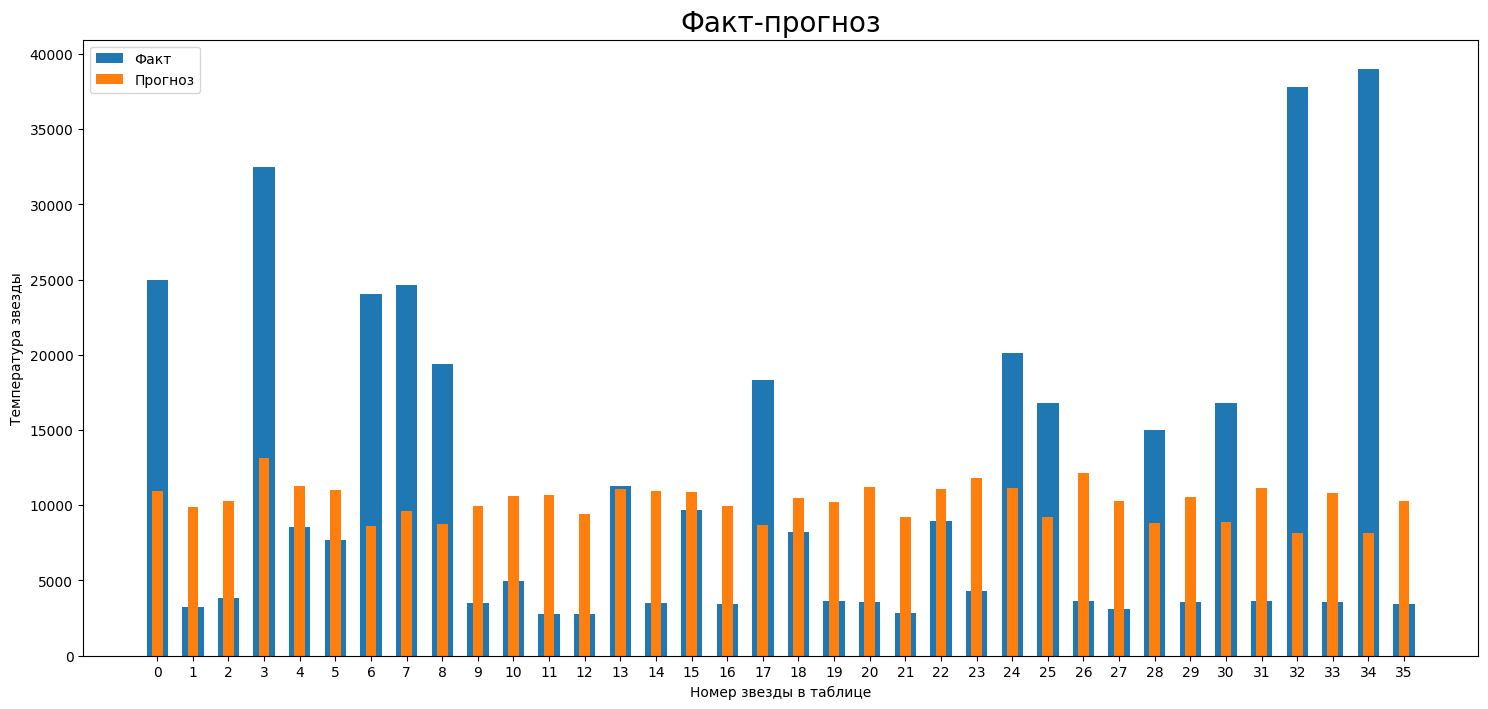

In [47]:
y1 = torch.FloatTensor(test_preds.cpu()).detach().numpy().reshape([-1])
y2 = y_test.detach().cpu().numpy().reshape([-1])
x = np.arange(len(y1))

fig,ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(8)
ax.set_xticks(x)
fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
ax.legend()
ax.set_title('Факт-прогноз', fontsize=20)
ax.set_xlabel('Номер звезды в таблице')
ax.set_ylabel('Температура звезды')
plt.show()

Как-то не очень, даже очень не. Давайте улучшим модель.

In [48]:


del(rmse1, rmse2, rmse3, net1, optimizer_arr, i, j, k, ind, Model1, Model2, Model3)


## Улучшение нейронной сети

Введём регуляризацию двух типов - нормализация батчей и отключение нейронов.

In [49]:
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, p):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp2 = nn.Dropout(p=p)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
     
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
       
        return x     

Введём диапазоны параметров сети, которые попробуем перебрать для поиска лучшей модели и желаемой точности. (

In [50]:
p_arr = [0.8, 0.5, 0.1, 0]
lr_arr = [0.01, 0.02, 0.025, 0.03, 0.035, 0.04]
batch_size_arr = [10,20,30,40,50,60,70,80,90,100,110,120,240]
num_epochs_arr = [1000, 1500, 2000, 10000]
logs = []

In [51]:
def finding_neverland(p, lr, batch_size, num_epochs):
    
    net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, p)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.MSELoss()
    num_batches = ceil(len(X_train)/batch_size)
    
    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
        
        optimizer.zero_grad()
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
    
            preds = net.forward(X_batch) 
                
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                
                optimizer.step()
                optimizer.zero_grad()
                
        if epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test)
            RMSE = torch.sqrt(loss(preds, y_test))
            return [torch.detach(RMSE).cpu().numpy(), p, lr, batch_size, num_epochs]
    

In [52]:
for p in p_arr:
    for lr in lr_arr:
        for batch_size in batch_size_arr:
            for num_epochs in num_epochs_arr:
                logs.append(finding_neverland(p, lr, batch_size, num_epochs))
                
url = f"https://api.telegram.org/bot6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA/sendMessage?chat_id=916785354&text=all_done"
print(requests.get(url).json())

{'ok': True, 'result': {'message_id': 58, 'from': {'id': 6015117129, 'is_bot': True, 'first_name': 'hi_from_jup', 'username': 'hi_from_jup_bot'}, 'chat': {'id': 916785354, 'first_name': 'Maria', 'username': 'maria_smiles', 'type': 'private'}, 'date': 1692448387, 'text': 'all_done'}}


In [53]:
url = f"https://api.telegram.org/bot6015117129:AAGCdFJKD8mCoJc3CdMN-4b7ktiEbhpAsYA/sendMessage?chat_id=916785354&text=dataFrame"
print(requests.get(url).json())
pd.DataFrame(logs, columns=['RMSE', 'p', 'lr', 'batch_size', 'num_epochs'])

{'ok': True, 'result': {'message_id': 59, 'from': {'id': 6015117129, 'is_bot': True, 'first_name': 'hi_from_jup', 'username': 'hi_from_jup_bot'}, 'chat': {'id': 916785354, 'first_name': 'Maria', 'username': 'maria_smiles', 'type': 'private'}, 'date': 1692448388, 'text': 'dataFrame'}}


,RMSE,p,lr,batch_size,num_epochs
0,10526.186,0.8,0.01,10,1000
1,10575.8545,0.8,0.01,10,1500
2,10364.548,0.8,0.01,10,2000
3,10367.82,0.8,0.01,10,10000
4,10489.587,0.8,0.01,20,1000
...,...,...,...,...,...
1243,10379.467,0.0,0.04,120,10000
1244,10397.704,0.0,0.04,240,1000
1245,10397.725,0.0,0.04,240,1500
1246,10397.715,0.0,0.04,240,2000


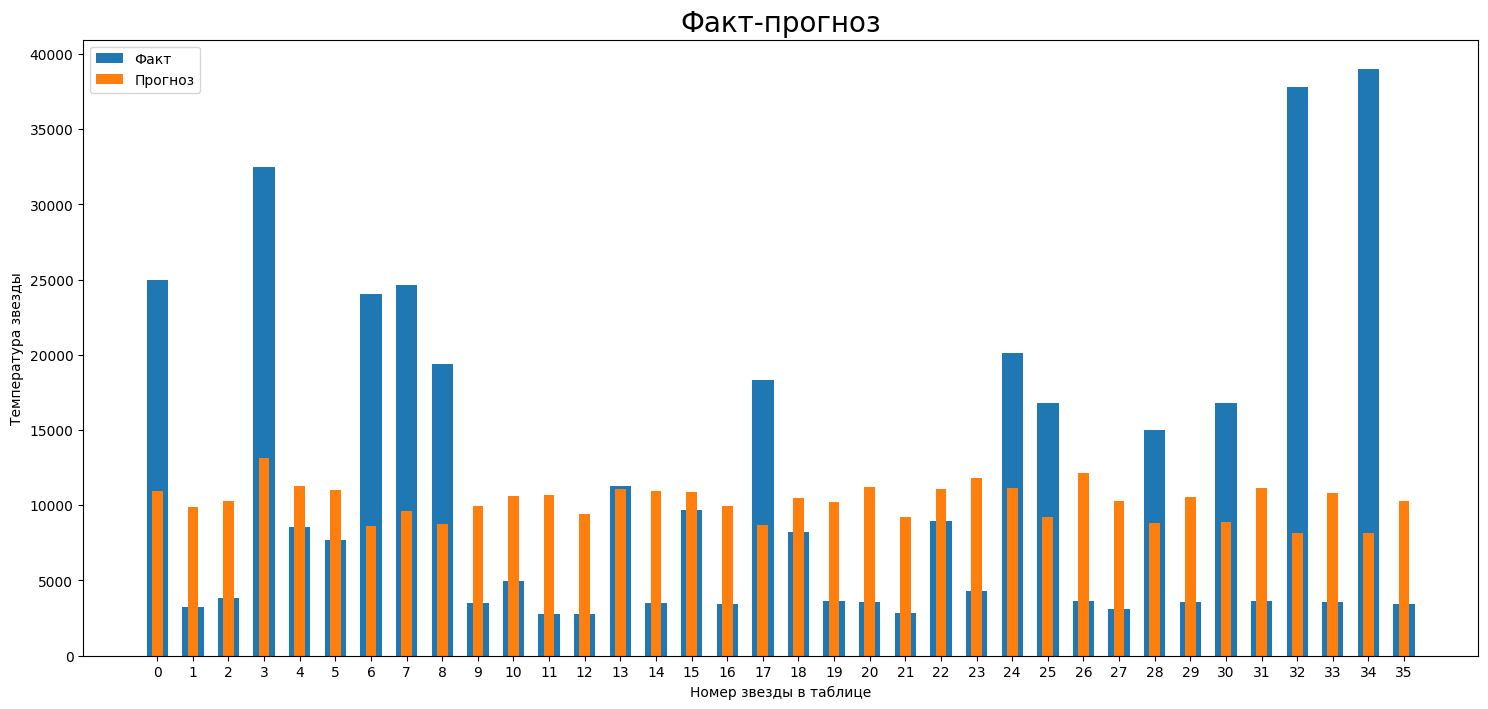

In [54]:
y1 = torch.FloatTensor(test_preds.cpu()).detach().numpy().reshape([-1])
y2 = y_test.detach().cpu().numpy().reshape([-1])
x = np.arange(len(y1))

fig,ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(8)
ax.set_xticks(x)
fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
ax.legend()
ax.set_title('Факт-прогноз', fontsize=20)
ax.set_xlabel('Номер звезды в таблице')
ax.set_ylabel('Температура звезды')
plt.show()

In [55]:
net_params = {
    'scaler' : scaler_list,
    'regressor__batch_size' : [10,20,30,40,50,60,70,80,90,100,110,120,240],
    'regressor__lr': [0.01, 0.02, 0.025, 0.03, 0.035, 0.04],
    'regerssor__max_epoch':[1000, 1500, 2000, 10000],
    'regressor__optimizer':[Adam, SGD, RMSprop],
    'regressor__module__dropout':[0.8, 0.5, 0.1, 0]
}

NameError: name 'scaler_list' is not defined

## Выводы